# Setup  

Bibliotecas

In [297]:
#Data wrangling
import pandas as pd 
import numpy as np

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder

#Models
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

#Remover warnings
import warnings 

#Save model
import pickle

#Set output as pandas
from sklearn import set_config
set_config(transform_output="pandas")



In [298]:
#Remover warnings
warnings.filterwarnings("ignore")


Dicionário para métricas

In [299]:
#Dicionário para métricas de classificação
def get_metrics(y_true, y_pred): #valores reais e previstos
    dict_metrics = {
        'Accuracy' : metrics.accuracy_score(y_true,y_pred),  #proporção de previsões corretas vs total
        'Balanced Accuracy' : metrics.balanced_accuracy_score(y_true,y_pred), #calcula a média entre a sensibilidade (recall) e a especificidade
        'Precision' : metrics.precision_score(y_true,y_pred), #proporção de positivos que realmente são positivos
        'Recall' : metrics.recall_score(y_true,y_pred), #proporção entre positivos reais que foram corretamente identificados 
        'F1' : metrics.f1_score(y_true, y_pred), #média harmonica entre precsion e recall
        'ROC_AUC' : metrics.roc_auc_score(y_true, y_pred) #capacidade do modelo em separar as classes (curva ROC, compara verd. pos. e fal. pos.)
           
    }
    
    return dict_metrics

# Business Understanding

A empresa fictícia analisada neste projeto é uma provedora de serviços de telecomunicações, oferecendo telefonia fixa e Internet residencial para 7.043 clientes no estado da Califórnia, durante o terceiro trimestre (Q3).

O objetivo principal deste estudo é compreender os fatores que levam à saída de clientes (churn), priorizar aqueles que apresentam maior risco e propor estratégias de retenção eficazes. Reduzir a rotatividade de clientes é essencial, já que impacta diretamente na receita recorrente da empresa e no custo de aquisição de novos clientes. Além disso, clientes com alto valor vitalício (Customer Lifetime Value - CLTV) precisam de atenção especial para evitar prejuízos financeiros maiores.

Perguntas-chave a serem respondidas:

Quais características mais contribuem para o churn?
Quais perfis de clientes são mais propensos a cancelar os serviços?
Quais estratégias podem ser implementadas para reter clientes, especialmente os mais valiosos?
Este estudo busca alavancar a análise de dados e métricas preditivas, como o Churn Score e o CLTV, para fornecer insights e ajudar na tomada de decisão estratégica.

# Data Understanding

O dataset utilizado neste projeto contém informações detalhadas sobre os clientes e suas 
interações com a empresa, totalizando 7.043 observações e 33 variáveis. Estas variáveis estão 
organizadas em categorias que refletem aspectos demográficos, contratuais, financeiros e 
comportamentais. Abaixo está a descrição das principais variáveis:

1. **Informações Gerais**
   - **CustomerID**: Identificação única de cada cliente.
   - **Count**: Quantidade de clientes em um conjunto filtrado para relatórios ou dashboards.
   - **Country, State, City, Zip Code**: Localização do cliente.
   - **Lat Long, Latitude, Longitude**: Coordenadas geográficas da residência do cliente.

2. **Características Demográficas**
   - **Gender**: Gênero do cliente (Masculino ou Feminino).
   - **Senior Citizen**: Indica se o cliente tem 65 anos ou mais (Sim ou Não).
   - **Partner**: Indica se o cliente possui um(a) parceiro(a) (Sim ou Não).
   - **Dependents**: Indica se o cliente possui dependentes, como filhos ou familiares (Sim ou Não).

3. **Serviços Contratados**
   - **Tenure Months**: Tempo total (em meses) que o cliente permaneceu com a empresa.
   - **Phone Service**: Indica se o cliente possui serviço de telefonia fixa (Sim ou Não).
   - **Multiple Lines**: Indica se o cliente possui múltiplas linhas telefônicas (Sim ou Não).
   - **Internet Service**: Tipo de serviço de Internet contratado (Nenhum, DSL, Fibra Óptica ou Cabo).
   - **Online Security, Online Backup, Device Protection, Tech Support**: 
     Indicam serviços adicionais contratados, como segurança online, backup de dados, proteção 
     de dispositivos ou suporte técnico prioritário (Sim ou Não).
   - **Streaming TV, Streaming Movies**: Indicam se o cliente utiliza o serviço de Internet para 
     assistir a TV ou filmes por terceiros (Sim ou Não).

4. **Informações Contratuais e Financeiras**
   - **Contract**: Tipo de contrato (Mensal, Um Ano ou Dois Anos).
   - **Paperless Billing**: Indica se o cliente optou por faturas digitais (Sim ou Não).
   - **Payment Method**: Método de pagamento utilizado pelo cliente (Débito Bancário, Cartão de 
     Crédito ou Cheque).
   - **Monthly Charge**: Valor mensal pago pelo cliente pelos serviços contratados.
   - **Total Charges**: Total acumulado pago pelo cliente até o final do trimestre.

5. **Indicadores de Churn**
   - **Churn Label**: Indica se o cliente cancelou os serviços no trimestre (Sim ou Não).
   - **Churn Value**: Representação numérica de Churn Label (1 = Saiu, 0 = Permaneceu).
   - **Churn Score**: Pontuação de 0 a 100, indicando a probabilidade de o cliente cancelar os 
     serviços.
   - **CLTV**: Valor vitalício do cliente. Clientes com valores altos são prioritários para 
     retenção.
   - **Churn Reason**: Motivo pelo qual o cliente cancelou os serviços (ex.: preço, atendimento, 
     qualidade do serviço).


In [300]:
#Carregando dataset 
df = pd.read_csv('..\data\customer_churn.csv', index_col= 'CustomerID') #carregando meus dados e definindo o index como a coluna de 'ID'
df

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,CLTV,Churn Value
CustomerID,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,3239,1
9237-HQITU,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,2701,1
9305-CDSKC,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,5372,1
7892-POOKP,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,5003,1
0280-XJGEX,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,5340,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569-WGERO,34.341737,-116.539416,Female,No,No,No,72,Yes,No,No,...,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,5306,0
6840-RESVB,34.667815,-117.536183,Male,No,Yes,Yes,24,Yes,Yes,DSL,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,2140,0
2234-XADUH,34.559882,-115.637164,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,5560,0


In [301]:
#Infos gerais do dataset 
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Latitude           7032 non-null   float64
 1   Longitude          7032 non-null   float64
 2   Gender             7032 non-null   object 
 3   Senior Citizen     7032 non-null   object 
 4   Partner            7032 non-null   object 
 5   Dependents         7032 non-null   object 
 6   Tenure Months      7032 non-null   int64  
 7   Phone Service      7032 non-null   object 
 8   Multiple Lines     7032 non-null   object 
 9   Internet Service   7032 non-null   object 
 10  Online Security    7032 non-null   object 
 11  Online Backup      7032 non-null   object 
 12  Device Protection  7032 non-null   object 
 13  Tech Support       7032 non-null   object 
 14  Streaming TV       7032 non-null   object 
 15  Streaming Movies   7032 non-null   object 
 16  Contract      

In [302]:
#Infos estatísticas de colunas categóricas 
df.describe()

,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,CLTV,Churn Value
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,36.283307,-119.799215,32.421786,64.798208,2283.300441,4401.445108,0.265785
std,2.456118,2.157588,24.545260,30.085974,2266.771362,1182.414266,0.441782
min,32.555828,-124.301372,1.000000,18.250000,18.800000,2003.000000,0.000000
25%,34.030915,-121.815412,9.000000,35.587500,401.450000,3469.750000,0.000000
50%,36.391777,-119.735410,29.000000,70.350000,1397.475000,4527.500000,0.000000
75%,38.227285,-118.043237,55.000000,89.862500,3794.737500,5381.000000,1.000000
max,41.962127,-114.192901,72.000000,118.750000,8684.800000,6500.000000,1.000000


**Insights**

**Tenure Months (Tempo de Permanência)**
- Há um número significativo de clientes com menos de 9 meses de permanência, o que pode representar um risco de churn inicial.

- É importante analisar se os clientes com menor permanência têm padrões específicos, como contratos de curto prazo ou serviços mais básicos.

**Monthly Charges (Cobrança Mensal)**
- Clientes com cobranças mensais mais baixas podem estar mais propensos ao churn, pois costumam ter menos serviços atrelados.

- Avaliar a relação entre valores pagos e churn pode ajudar a entender se clientes de planos premium são mais fiéis.

**Total Charges (Cobrança Total)**
- Há um grupo significativo de novos clientes (valores baixos em Total Charges), que deve ser monitorado para evitar churn precoce.

- Clientes com altos valores acumulados tendem a ser mais fiéis, mas é importante garantir que continuem satisfeitos.

**Churn Value**
- A taxa de churn (27%) é relativamente alta. Focar em fatores que contribuem para a rotatividade pode ajudar a reduzir este valor.

- Analisar variáveis associadas ao churn (como Tenure Months e Monthly Charges) pode revelar padrões importantes.

In [303]:
#Dados duplicados 
df.duplicated().sum()

0

In [304]:
#Dados nulos
df.isnull().sum()

Latitude             0
Longitude            0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
CLTV                 0
Churn Value          0
dtype: int64

In [305]:
#Valores na coluna target 
df['Churn Value'].value_counts()

Churn Value
0    5163
1    1869
Name: count, dtype: int64

In [306]:
#Propoção de não churn (0)
df['Churn Value'].eq(0).sum()/ df.shape[0]

0.7342150170648464

## Exploratory Data Analysis (EDA)

Distribuição de Churn

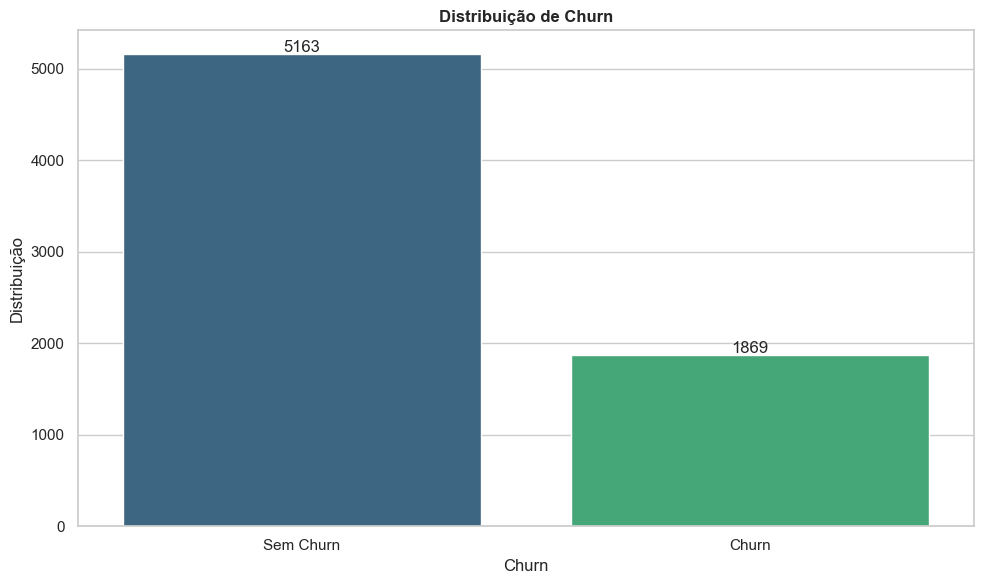

In [307]:
#Análise visual de churn 
churn_counts = df['Churn Value'].value_counts()
fig = plt.figure(figsize=[10,6])
sns.barplot(x= churn_counts.index, y= churn_counts.values, palette= 'viridis')

#Titulo e eixos 
plt.title('Distribuição de Churn', fontweight = 'bold')
plt.xlabel('Churn')
plt.ylabel('Distribuição')
plt.xticks(ticks=[0,1], labels= ['Sem Churn', 'Churn'])

#Mostrando valores nas barras 
for i, value in enumerate(churn_counts.values):  #indice e valor em churn counts (i = 0 ou 1, value = total de valores)
        plt.text(i, value+20, f'{value}', ha= 'center')  #valores em cada barra com deslocamento +20 de espacamento acima da barra
        
plt.tight_layout()
plt.show()

Churn vs Gêneros

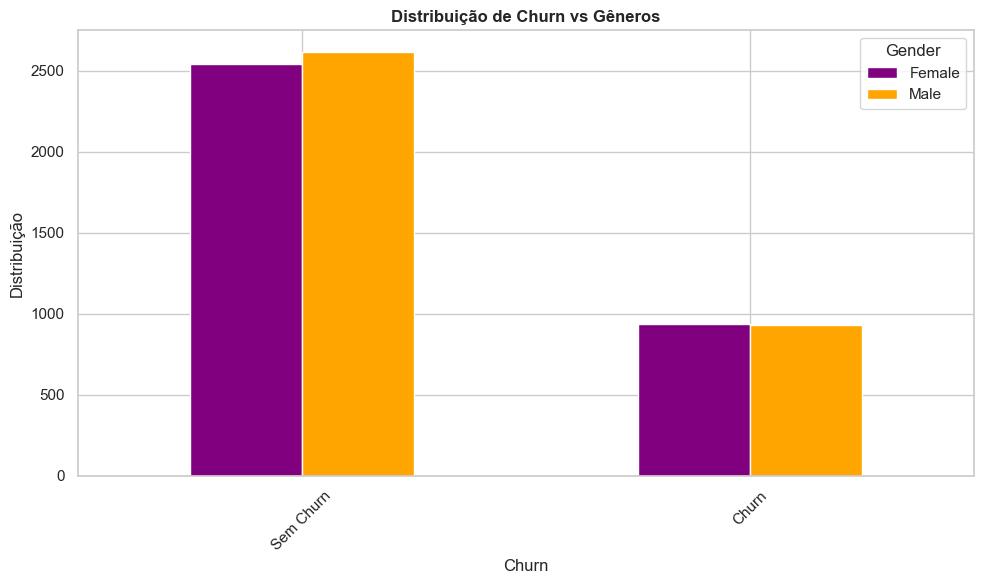

In [308]:

#Agrupando os dados
gender_churn = df.groupby(['Churn Value', 'Gender']).size().unstack(fill_value=0)

#Plotando o gráfico com barras separadas por gênero
gender_churn.plot(kind='bar', figsize=(10, 6), color=['purple', 'orange'])

#Título e rótulos
plt.title('Distribuição de Churn vs Gêneros', fontweight='bold')
plt.xlabel('Churn')
plt.ylabel('Distribuição')

#Alterando os ticks do eixo X com rotação
plt.xticks(ticks=[0, 1], labels=['Sem Churn', 'Churn'], rotation=45)

#Exibindo o gráfico
plt.tight_layout()
plt.show()



Churn vs Idade Senior (maior que 65 anos)

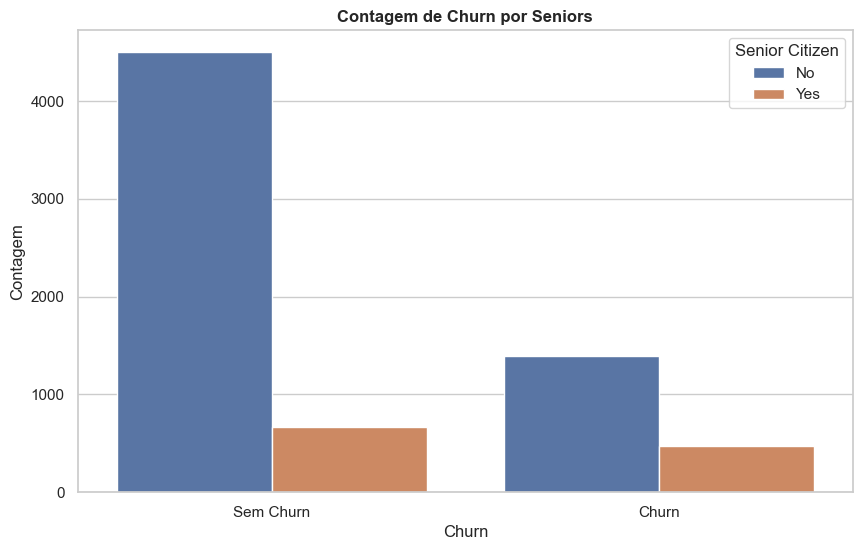

In [309]:
#Gráfico de contagem
fig = plt.figure(figsize=(10,6))
sns.countplot(data= df, x= 'Churn Value', hue= 'Senior Citizen', palette= 'deep')


#Titulo e eixos 
plt.title('Contagem de Churn por Seniors', fontweight = 'bold')
plt.xlabel('Churn')
plt.ylabel('Contagem')
plt.xticks(ticks= [0,1], labels= ['Sem Churn', 'Churn'])

plt.tight_layout
plt.show()

Churn vs Método de Pagamento

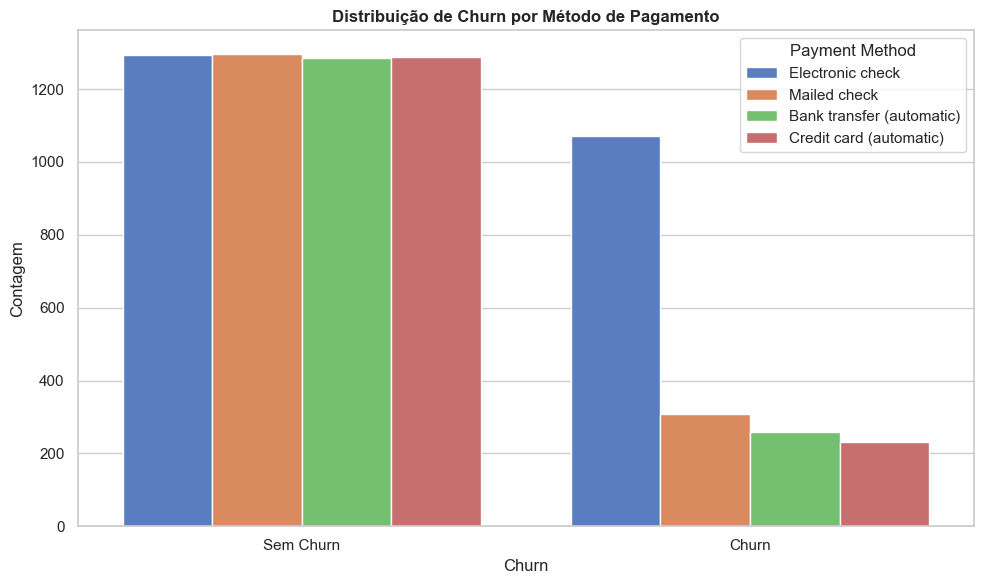

In [310]:
#Gráfico de barras para churn por método de pagamento
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Churn Value', hue='Payment Method', palette='muted')

#Títulos e rótulos
plt.title('Distribuição de Churn por Método de Pagamento', fontweight='bold')
plt.xlabel('Churn')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Sem Churn', 'Churn'])

#Exibindo o gráfico
plt.tight_layout()
plt.show()

Churn vs Tempo de Permanencia

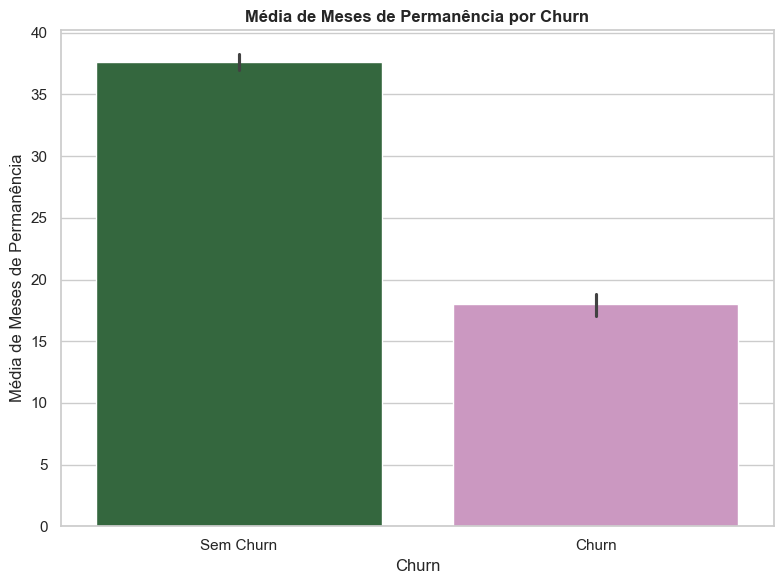

In [311]:
#Gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(data=df, x='Churn Value', y='Tenure Months', palette='cubehelix')

#Títulos e rótulos
plt.title('Média de Meses de Permanência por Churn', fontweight='bold')
plt.xlabel('Churn')
plt.ylabel('Média de Meses de Permanência')
plt.xticks(ticks=[0, 1], labels=['Sem Churn', 'Churn'])

#Exibindo o gráfico
plt.tight_layout()
plt.show()


In [312]:
#Features numericas
numerical_columns = df.select_dtypes(['float64', 'int64']).columns
numerical_columns

Index(['Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges',
       'Total Charges', 'CLTV', 'Churn Value'],
      dtype='object')

In [313]:
#Features categoricas
categorical_columns = df.select_dtypes('object').columns
categorical_columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method'],
      dtype='object')

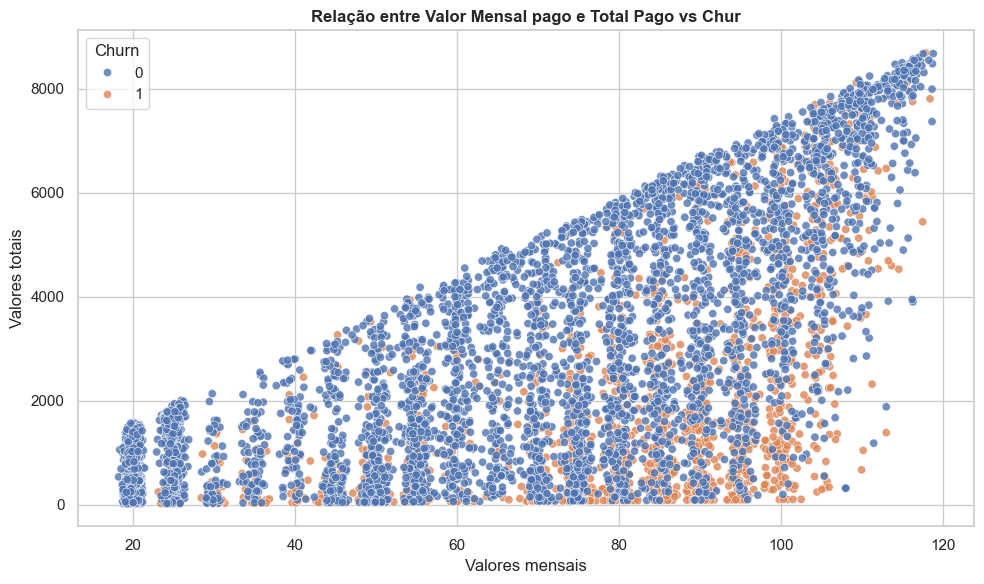

In [314]:
#Grafico de dispersão entre valor mensal e valor total vs churn
fig = plt.figure(figsize=(10,6))
sns.scatterplot(data= df, x= 'Monthly Charges', y = 'Total Charges', hue= 'Churn Value', alpha = 0.8)

#Titulo e eixos 
plt.title('Relação entre Valor Mensal pago e Total Pago vs Chur', fontweight = 'bold')
plt.xlabel('Valores mensais')
plt.ylabel('Valores totais')
plt.legend(title='Churn')

plt.tight_layout()
plt.show()


Insights:

- Clientes pagando valores mensais relativamente altos, entre **70 e 100** reais mensais. parecem ter maior probabilidade de churn. Isso pode estar associado a insatisfação com o custo-benefício percebido ou alta sensibilidade ao preço.

- Clientes novos, com um total acumulado até 2000 reais, podem ser mais propensos a churn, seja por não estarem satisfeitos no início ou por não terem um contrato longo.

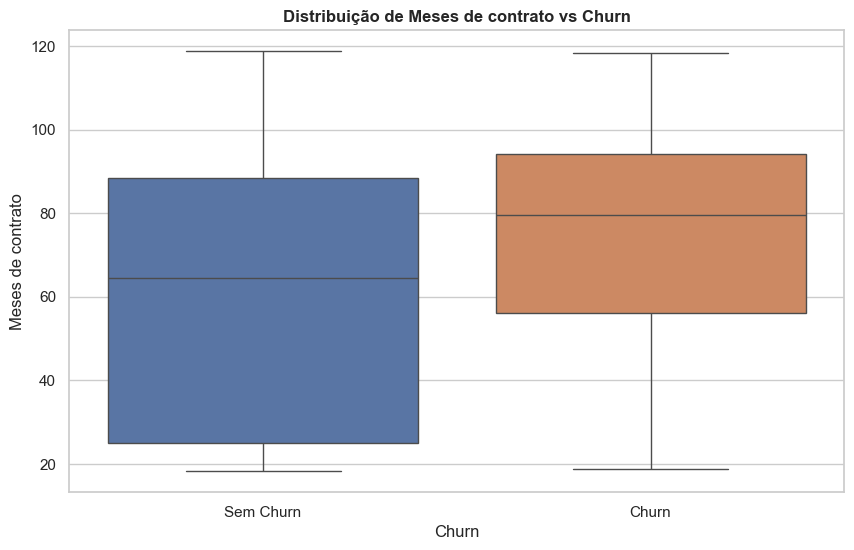

In [315]:
#Box plot Meses de contrato vs Churn
plt.figure(figsize=(10, 6))
sns.boxplot(  data=df, x="Churn Value", y="Monthly Charges", palette= 'deep')
plt.title("Distribuição de Meses de contrato vs Churn", fontweight = 'bold')
plt.xlabel("Churn")
plt.ylabel("Meses de contrato")
plt.xticks(ticks=[0,1], labels= ['Sem Churn', 'Churn'])
plt.show()

- Com esse boxplot podemos reforçar a nossa tese que clientes que pagam valores **mensais mais altos** estão mais propensos a **churn**

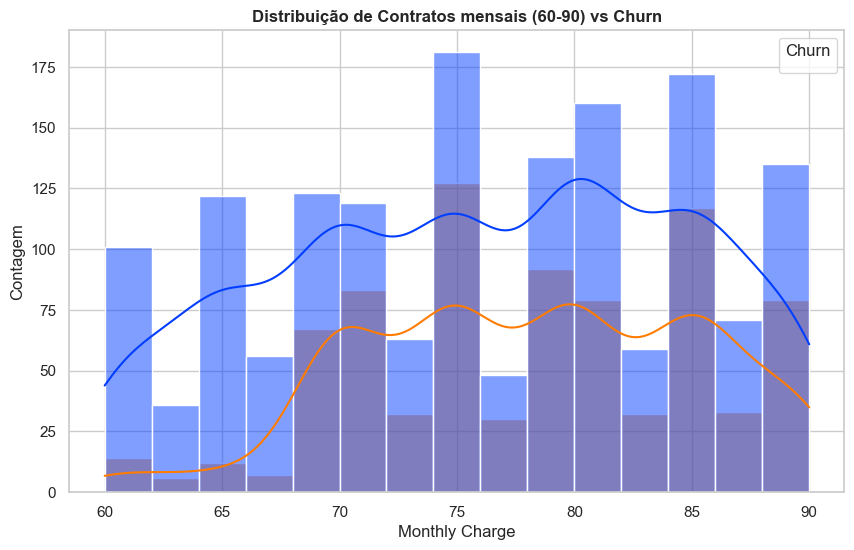

In [316]:
# Criar o histograma com cores vibrantes
plt.figure(figsize=(10, 6))
sns.histplot( data=df[(df["Monthly Charges"] >= 60) & (df["Monthly Charges"] <= 90)], x="Monthly Charges", hue="Churn Value", kde= True, palette= 'bright')
plt.title('Distribuição de Contratos mensais (60-90) vs Churn', fontweight = 'bold')
plt.xlabel('Monthly Charge')
plt.ylabel('Contagem')
plt.legend(title='Churn')
plt.show()



Na faixa entre os valores mensais gastos entre 60 e 90 dos clientes, podemos ver que o pico de clientes que relizam o churn fica entre 70 e 90.

**Correlações**

In [317]:
#Correlações entre variáveis numéricas
df[numerical_columns].corr()


,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,CLTV,Churn Value
Latitude,1.000000,-0.876777,-0.002100,-0.020302,-0.010313,0.000137,-0.003600
Longitude,-0.876777,1.000000,-0.001477,0.024513,0.009047,0.000953,0.004693
Tenure Months,-0.002100,-0.001477,1.000000,0.246862,0.825880,0.396188,-0.354049
Monthly Charges,-0.020302,0.024513,0.246862,1.000000,0.651065,0.098565,0.192858
Total Charges,-0.010313,0.009047,0.825880,0.651065,1.000000,0.341837,-0.199484
CLTV,0.000137,0.000953,0.396188,0.098565,0.341837,1.000000,-0.128253
Churn Value,-0.003600,0.004693,-0.354049,0.192858,-0.199484,-0.128253,1.000000


Heatmap

<Axes: >

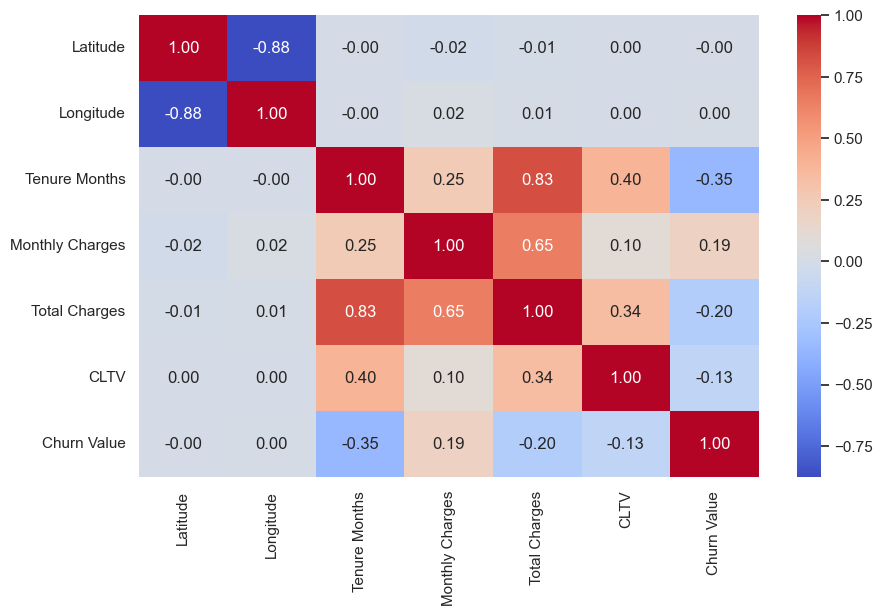

In [318]:
#Heat map
fig = plt.figure(figsize=(10,6))

#Mask para o gráfico
mask = np.triu(np.ones_like(df[numerical_columns].corr(), dtype=bool)) #matriz de zeros do mesmo tamanho do meu df e convertendo em boolean

#Gráfico
sns.heatmap(data= df[numerical_columns].corr(), annot= True, fmt= '.2f', cmap= 'coolwarm')



- Monthly Charges (valores de contrato mensais) mais altos tem maior probabilidade de churn, como vimos anteriormente.

**Distribuição de Variáveis Categoricas vs Churn**

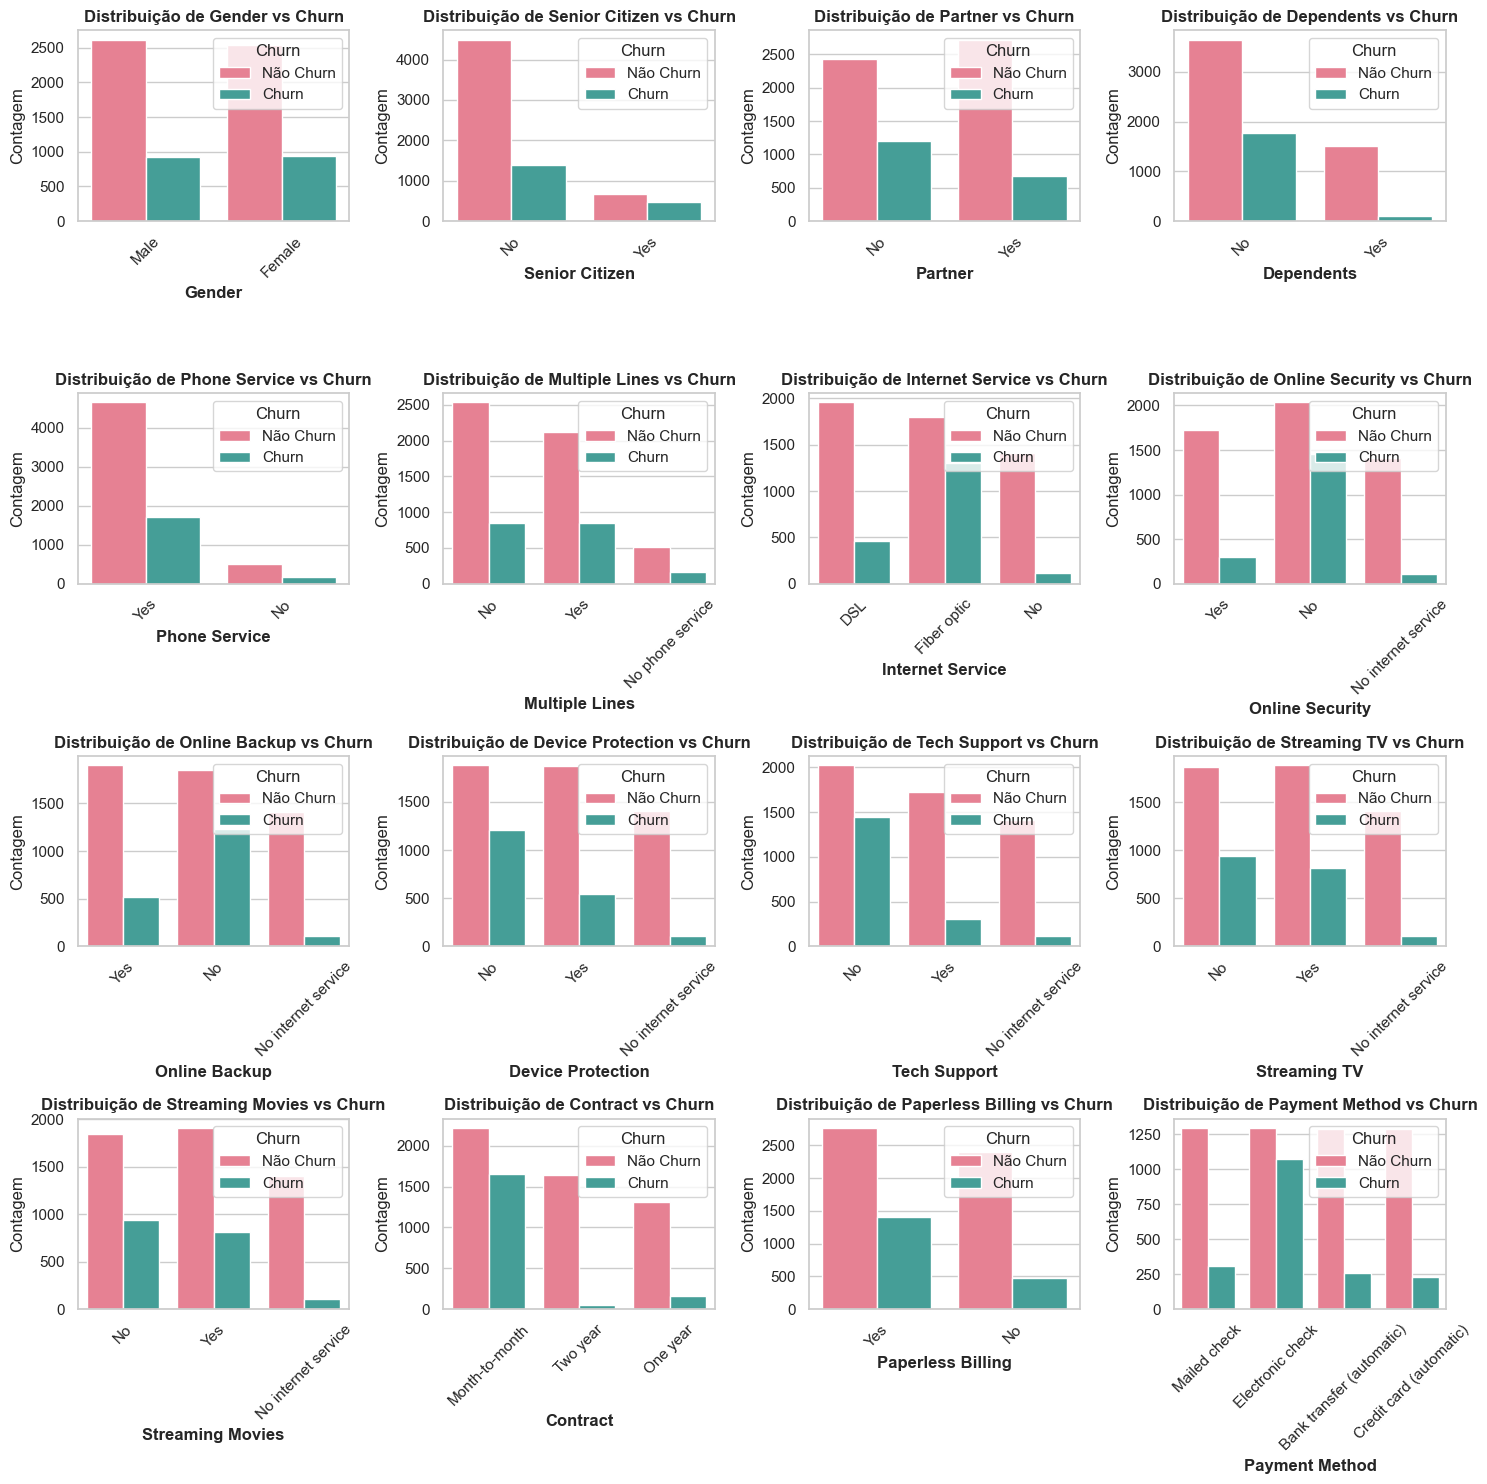

In [319]:
#Configurar subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
axes = axes.flatten()  # Flatten para acessar os eixos facilmente

#Criar os gráficos para cada variável categórica
for i, column in enumerate(categorical_columns):
    sns.countplot(data=df,  x=column,  hue='Churn Value', palette='husl', ax=axes[i])
    
    #Titulos e eixos
    axes[i].set_title(f'Distribuição de {column} vs Churn', fontweight='bold')
    axes[i].set_xlabel(column, fontweight='bold')
    axes[i].set_ylabel('Contagem')
    axes[i].legend(title='Churn', labels=['Não Churn', 'Churn'])
    axes[i].tick_params(axis = 'x', rotation=45)

# Ajustar layout
plt.tight_layout()
plt.show()


**Principais Insights sobre o Comportamento de Churn**

- Clientes sem dependentes estão mais propensos a cancelar os serviços:

Os dados mostram que clientes sem dependentes apresentam taxas de churn significativamente maiores quando comparados aos que possuem dependentes. Isso pode indicar que clientes solteiros ou sem obrigações familiares são mais sensíveis a mudanças ou menos leais ao serviço.

- Internet via fibra óptica está associada a maiores taxas de churn:

Clientes que utilizam fibra óptica como tipo de conexão de internet demonstram maior propensão a cancelar os serviços, em comparação com outras tecnologias (como DSL ou ausência de internet). A possível causa pode estar relacionada a problemas de custo ou qualidade percebida.

- Falta de segurança online contribui para o churn:

Clientes que não possuem o serviço de segurança online apresentam maiores taxas de churn. Isso pode estar relacionado à percepção de vulnerabilidade ou insatisfação com a oferta de serviços adicionais.

- Suporte técnico insuficiente aumenta o risco de churn:

Os clientes que não têm suporte técnico contratado são mais propensos a cancelar os serviços. Isso sugere que o suporte técnico é um fator-chave na retenção de clientes, talvez por impactar diretamente a experiência do usuário.

- Pagamentos mensais estão fortemente associados ao churn:

Clientes com contratos mensais apresentam taxas de churn muito superiores aos que optam por contratos anuais ou bienais. Isso pode indicar que contratos curtos oferecem maior flexibilidade para cancelamento e menos fidelização em comparação a contratos de longo prazo.

- Pagamento via cheque eletrônico está associado a maior churn:

Clientes que utilizam cheque eletrônico como método de pagamento mostram taxas de churn mais altas em relação a outros métodos, como débito automático ou cartão de crédito. Isso pode ser reflexo de uma experiência de pagamento menos conveniente ou clientes menos comprometidos.



## Feature Importances

**Confirmando features mais importantes do dataset com Random Forest**

In [320]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#Separar as features e a variável-alvo
X = df[['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
        'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup',
        'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
        'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges']]
y = df['Churn Value']



In [321]:
#One-hot encoding das variáveis categóricas
X = pd.get_dummies(X, drop_first=True)

#Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [322]:
# Treinar o modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [323]:
# Importância das features
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


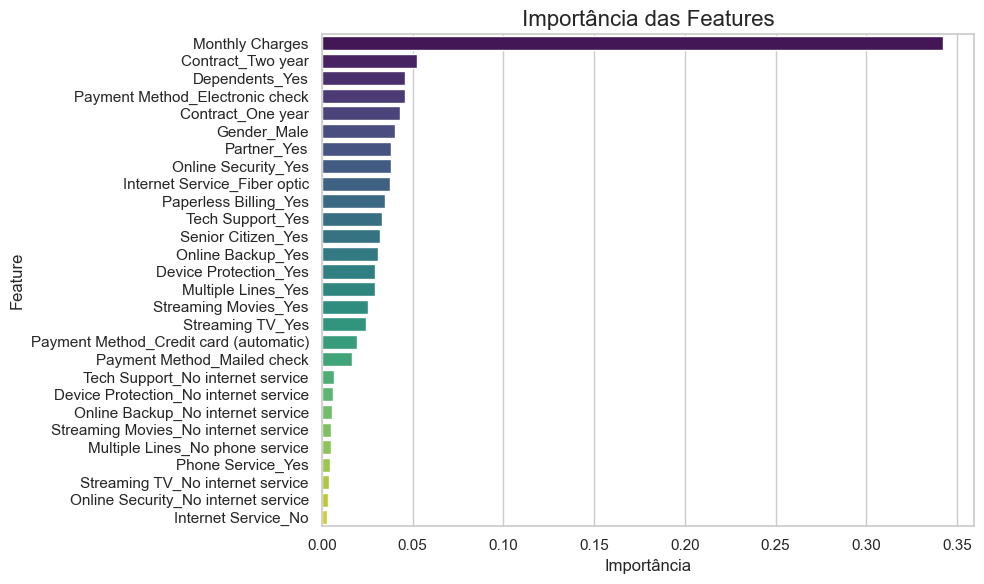

In [324]:
#Configurar o estilo do Seaborn
sns.set(style="whitegrid")

#Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')

# dicionar títulos e labels
plt.title('Importância das Features', fontsize=16)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()

# Mostrar o gráfico
plt.show()

Insights gerais

**Features mais importante**:

A variável **"Monthly Charges"** possui a maior importância, indicando que ela tem um impacto significativo no modelo ou na predição do alvo. Isso sugere que os valores cobrados mensalmente são um fator determinante.

Contrato é relevante:

- Contratos de **"Two year" e "One year"** aparecem como características relevantes. Isso indica que o tipo de contrato influencia fortemente o comportamento ou o desfecho analisado, talvez relacionado à retenção de clientes ou à probabilidade de churn.

Dependência de clientes:

- A presença de dependentes (**"Dependents_Yes"**) é relevante, destacando que clientes com dependentes podem ter um padrão distinto.

Método de pagamento:

- O método de pagamento, especialmente **"Electronic check"**, tem uma alta relevância, sugerindo que pode haver uma relação entre este método e o comportamento analisado.

Serviços adicionais:

- Variáveis como **"Online Security_Yes"**, **"Tech Support_Yes"**, e **"Device Protection_Yes"** também são importantes, indicando que a adesão a serviços adicionais tem impacto significativo.

Menor relevância:

- Features relacionadas a "No internet service" e "No phone service" possuem pouca ou nenhuma relevância no modelo, sugerindo que esses casos têm menor variabilidade ou não contribuem muito para a predição.

**Com isso vamos selecionar as features mais importantes para o nosso modelo.**

# **Modelling e Evaluation**

In [325]:
#Definindo as features numéricas e categoricas como as mais importante
NUMERICAL_FEATURES = ['Monthly Charges', 'Total Charges','Tenure Months']

CATEGORICAL_FEATURES = [ 
    'Gender',
    'Senior Citizen',
    'Partner',
    'Dependents',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Contract',
    'Paperless Billing',
    'Payment Method']

#Definindo features (X) e target (y)
FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES

TARGET = 'Churn Value'

In [326]:
#Definindo X e y
X = df[FEATURES]
y = df[TARGET]

#Treinando o modelo
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, stratify= y, random_state= 2024)

**Pipelines**

In [327]:
#Normalização e padronização dos dados
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), NUMERICAL_FEATURES), #média 0 e variança 1
    ('enconder', OneHotEncoder(drop= 'if_binary', sparse_output= False ), CATEGORICAL_FEATURES)  #dropando colunas redundantes p/ cat. binárias e saída de matriz densa
])

preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Monthly Charges', 'Total Charges',
                                  'Tenure Months']),
                                ('enconder',
                                 OneHotEncoder(drop='if_binary',
                                               sparse_output=False),
                                 ['Gender', 'Senior Citizen', 'Partner',
                                  'Dependents', 'Online Security',
                                  'Online Backup', 'Device Protection',
                                  'Tech Support', 'Streaming TV',
                                  'Streaming Movies', 'Contract',
                                  'Paperless Billing', 'Payment Method'])])

In [328]:
#Pipeline 
model_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model', DummyClassifier())  #estabelecendo um baseline para comparar com outros modelos      
])

model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Monthly Charges',
                                                   'Total Charges',
                                                   'Tenure Months']),
                                                 ('enconder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('model', DummyClassifier())])

In [329]:
#Parameters
paramns = {
    'model': [
        LogisticRegressionCV(max_iter= 1_000),
        RandomForestClassifier(random_state= 2024),
        GradientBoostingClassifier(random_state= 2024),
        LGBMClassifier(random_state= 2024),
        DummyClassifier       
    ]  
}

Grid Search

In [330]:
#Utilizando GridSearch para encontrar os melhores parametros 
grid = GridSearchCV(model_pipeline, paramns, cv=3, scoring= 'f1', n_jobs= -1, verbose= 1 )
grid.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'Tenure '
                                                                          'Months']),
                                                                        ('enconder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       sparse_output=False),
                                                                         ['Gender',
                                                                          'Senior '
                                                                          'Citizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'Online '
                                                                          'Security',
                                                                          'Online '
                                                                          'Backup',
                                                                          'Device '
                                                                          'Protection',
                                                                          'Te...
                                                                          'Streaming '
                                                                          'Movies',
                                                                          'Contract',
                                                                          'Paperless '
                                                                          'Billing',
                                                                          'Payment '
                                                                          'Method'])])),
                                       ('model', DummyClassifier())]),
             n_jobs=-1,
             param_grid={'model': [LogisticRegressionCV(max_iter=1000),
                                   RandomForestClassifier(random_state=2024),
                                   GradientBoostingClassifier(random_state=2024),
                                   LGBMClassifier(random_state=2024),
                                   <class 'sklearn.dummy.DummyClassifier'>]},
             scoring='f1', verbose=1)

In [331]:
#Ordenando resultados dos hiperparâmetros
df_grid_results = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index() #definindo rank test como indice e ordenando pelos melhores

#Procuando colunas que contenham 'split e fit' e excluindo-as
df_grid_results.iloc[:, ~df_grid_results.columns.str.contains('split | fit') ]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,
1,1.662280,0.046934,0.113537,0.008329,LogisticRegressionCV(max_iter=1000),{'model': LogisticRegressionCV(max_iter=1000)},0.595438,0.623472,0.615385,0.611432,0.011781
2,2.524030,0.010385,0.066130,0.004813,GradientBoostingClassifier(random_state=2024),{'model': GradientBoostingClassifier(random_st...,0.602500,0.597911,0.575758,0.592056,0.011676
3,1.706812,0.156644,0.087105,0.004070,LGBMClassifier(random_state=2024),{'model': LGBMClassifier(random_state=2024)},0.586634,0.593156,0.583639,0.587809,0.003973
4,1.941722,0.069352,0.261455,0.042400,RandomForestClassifier(random_state=2024),{'model': RandomForestClassifier(random_state=...,0.541296,0.551724,0.524548,0.539189,0.011194
5,0.097962,0.002626,0.000000,0.000000,<class 'sklearn.dummy.DummyClassifier'>,{'model': <class 'sklearn.dummy.DummyClassifie...,NaN,NaN,NaN,NaN,NaN


Melhor modelo: **Logistic Regression**

In [332]:
#Pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegressionCV(
    cv=5,  # Validação cruzada interna
    scoring='f1',  # F1 como métrica principal
    max_iter=1000,  # Número máximo de iterações
    class_weight='balanced',  # Balanceamento automático das classes
    random_state=2024  # Reprodutibilidade
))

])

#Definindo os parametros p serem usados no GridSearch
params = {
    'preprocessor__scaler': [StandardScaler(), PowerTransformer()],  #Teste de diferentes transformações
    'model__Cs': [10, 50, 100],  #Número de valores de C testados pelo LogisticRegressionCV
    'model__solver': ['lbfgs', 'liblinear']  #Teste de diferentes otimizadores
}

#Treinando com GridSearch
grid = GridSearchCV(model_pipeline, params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

#Ordenando registros
df_grid_results = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
filtered_results = df_grid_results.iloc[:,~df_grid_results.columns.str.contains('split|fit')]

filtered_results

Fitting 3 folds for each of 12 candidates, totalling 36 fits


,mean_score_time,std_score_time,param_model__Cs,param_model__solver,param_preprocessor__scaler,params,mean_test_score,std_test_score
rank_test_score,,,,,,,,
1,0.089174,0.008506,100,lbfgs,PowerTransformer(),"{'model__Cs': 100, 'model__solver': 'lbfgs', '...",0.632460,0.010828
2,0.085647,0.008517,50,lbfgs,PowerTransformer(),"{'model__Cs': 50, 'model__solver': 'lbfgs', 'p...",0.632078,0.011064
3,0.144203,0.052280,50,liblinear,PowerTransformer(),"{'model__Cs': 50, 'model__solver': 'liblinear'...",0.631107,0.013631
3,0.067393,0.013180,100,liblinear,PowerTransformer(),"{'model__Cs': 100, 'model__solver': 'liblinear...",0.631107,0.013631
5,0.188205,0.042229,10,liblinear,PowerTransformer(),"{'model__Cs': 10, 'model__solver': 'liblinear'...",0.630687,0.013363
6,0.154388,0.076701,10,lbfgs,PowerTransformer(),"{'model__Cs': 10, 'model__solver': 'lbfgs', 'p...",0.630657,0.013356
7,0.178086,0.035871,10,liblinear,StandardScaler(),"{'model__Cs': 10, 'model__solver': 'liblinear'...",0.625937,0.010865
8,0.095996,0.005593,10,lbfgs,StandardScaler(),"{'model__Cs': 10, 'model__solver': 'lbfgs', 'p...",0.625344,0.009845
9,0.135640,0.028104,100,lbfgs,StandardScaler(),"{'model__Cs': 100, 'model__solver': 'lbfgs', '...",0.624988,0.008648


In [333]:
# Melhor modelo encontrado
best_model = grid.best_estimator_
print("Melhores Parâmetros:", grid.best_params_)
print("Melhor F1-Score:", grid.best_score_)

Melhores Parâmetros: {'model__Cs': 100, 'model__solver': 'lbfgs', 'preprocessor__scaler': PowerTransformer()}
Melhor F1-Score: 0.6324596622995211


**Tunning**

In [334]:
#Tunando o modelo e fazendo a predição
tunned_model = grid.best_estimator_   #retorna o melhor modelo (com scoring = 'f1')
y_pred =  tunned_model.predict(X_test)


**Metrics**

In [335]:
#Obtendo as métricas com a função criada def get_metrics
get_metrics(y_test, y_pred)

{'Accuracy': 0.7819905213270142,
 'Balanced Accuracy': 0.7946694377028938,
 'Precision': 0.561510353227771,
 'Recall': 0.82174688057041,
 'F1': 0.6671490593342981,
 'ROC_AUC': 0.7946694377028939}

Matriz de Confusão (Heatmap)

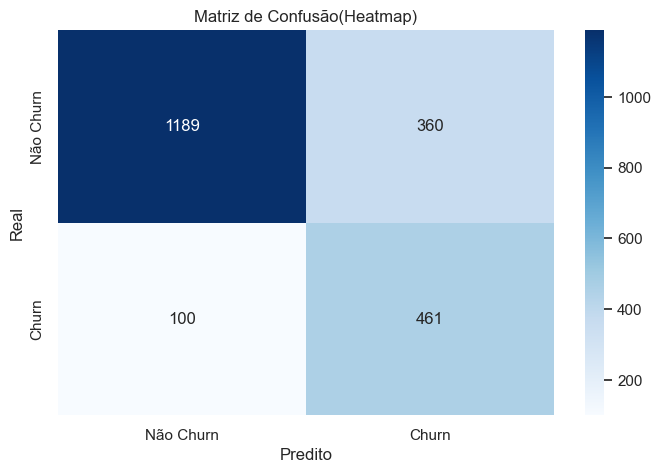

In [360]:
#Matriz de confusão
cm = confusion_matrix(y_test, best_model.predict(X_test))
plt.figure(figsize=(8,5))

#Plotando o grafico
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=["Não Churn", "Churn"], yticklabels=["Não Churn", "Churn"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão(Heatmap)")
plt.show()

Insights:

O modelo possui um bom desempenho geral, porém apresenta alguns falsos positivos e falsos negativos que podem impactar a tomada de decisão.

**Falsos Positivos (360 casos - do total de "Não Churn")**

- O modelo previu churn para clientes que não cancelaram.

**Falsos Negativos (100 casos - do total de "Churn")**

- O modelo não identificou 100 clientes que realmente cancelaram.

**Verdadeiros Positivos (461 - 82.2% dos churns foram detectados corretamente)**

- O modelo está capturando bem os churns, mas pode ser melhorado.

**Verdadeiros Negativos (1189 - 76.8% dos não churns foram corretamente classificados)**

- Indica que a maioria dos clientes que não cancelaram foram corretamente identificados.



Curva ROC

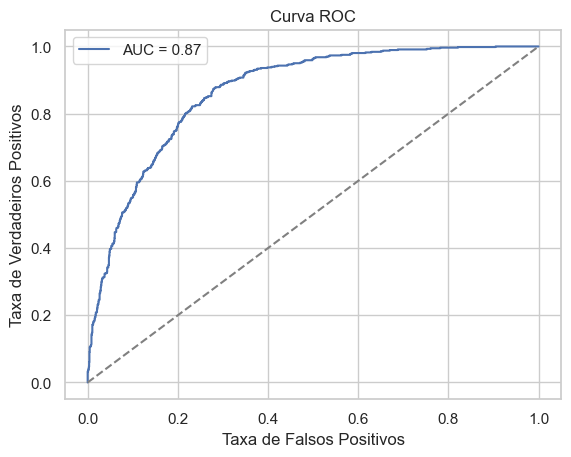

In [337]:
#Prevendo probabilidades para a classe positiva
y_prob = tunned_model.predict_proba(X_test)[:, 1]

#Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

#Calculando a AUC
auc_score = roc_auc_score(y_test, y_prob)

#Plotando a curva ROC
plt.figure()
plt.plot(fpr, tpr, label= f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Curva ROC")
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.legend()
plt.show()

Insights:

**AUC = 0.87** indica um bom desempenho

- Um AUC de 0.87 significa que o modelo tem 87% de chance de classificar corretamente uma amostra aleatória de churn e não churn.



In [338]:
#Aplicando no modelo de Lr 
lr_model = tunned_model.named_steps['model']  #define o lr recuperando o lr do pipeline e com o tunning

#Extraindo os coeficientes
coef = pd.Series(
    data = lr_model.coef_[0],
    index = lr_model.feature_names_in_ #mostra os nomes das features utilizadas no training

)

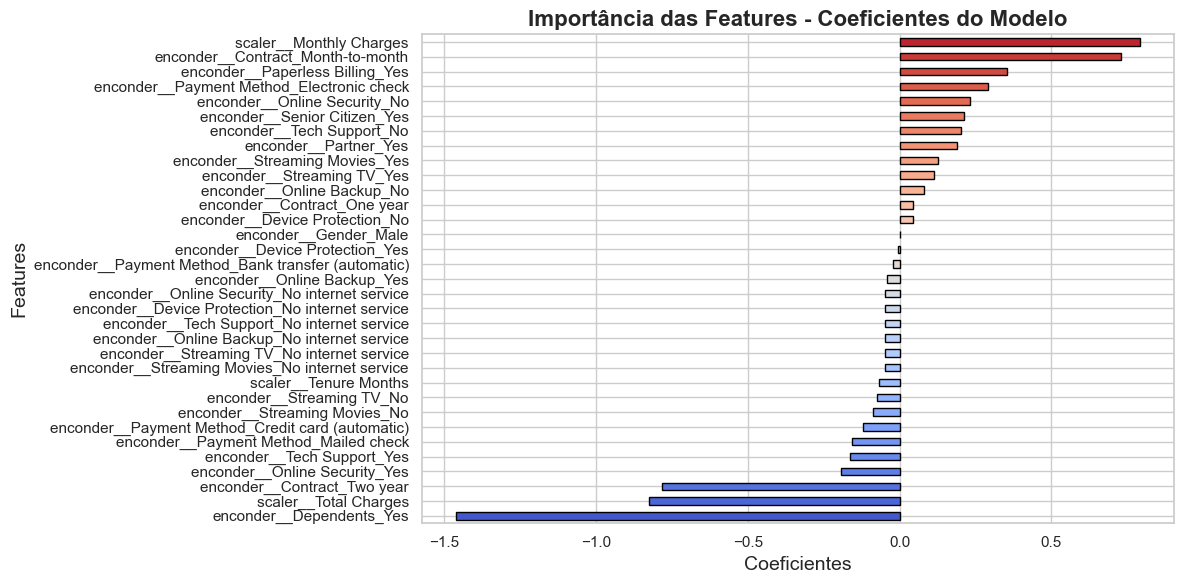

In [339]:
#Oredenando os coeficientes 
coef_sorted = coef.sort_values()

#Configuração do estilo
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")  #fundo com grades discretas

#Gráfico de barras horizontais
palette = sns.color_palette("coolwarm", len(coef_sorted)) #definindo a paleta de cores como 'coolwarm' de acordo com cada coef
coef_sorted.plot.barh(color=palette, edgecolor='black') #definindo a palete de cores e colocando contornos pretos

#Adicionando título e rótulos
plt.title("Importância das Features - Coeficientes do Modelo",fontweight = 'bold', fontsize=16, loc= 'center')
plt.xlabel("Coeficientes", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [ ]:
#Adicionando as predições do modelo ajustado (`tunned_model`) à base de teste
df_results = X_test.assign(Churn=y_test).assign(Label=tunned_model.predict(X_test))
df_results


,Monthly Charges,Total Charges,Tenure Months,Gender,Senior Citizen,Partner,Dependents,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Churn,Label
CustomerID,,,,,,,,,,,,,,,,,,
9108-EJFJP,53.55,53.55,1,Female,No,Yes,No,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,0,1
2190-PHBHR,94.45,6921.70,72,Female,No,Yes,No,Yes,Yes,No,No,No,Yes,Two year,Yes,Credit card (automatic),0,0
4868-AADLV,116.25,7862.25,66,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,0,0
7426-GSWPO,103.50,6548.65,64,Male,Yes,No,No,Yes,Yes,No,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),0,1
8735-SDUFN,24.30,1778.70,72,Female,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6416-JNVRK,55.65,2688.85,46,Female,No,No,No,No,No,No,No,No,Yes,One year,No,Credit card (automatic),0,0
6181-AXXYF,24.75,1859.10,72,Male,No,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0,0
6024-RUGGH,25.20,1798.90,72,Male,No,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),0,0


**Comparação dos valores reais vs previstos**

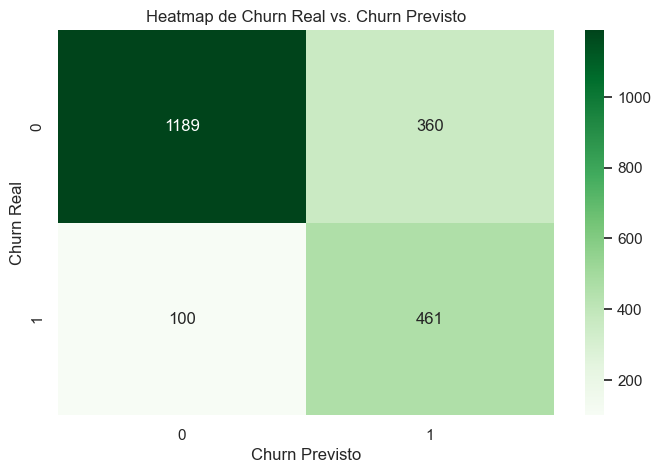

In [358]:
#Criando uma tabela de contagem para gerar o heatmap (matriz confusão)
df_heatmap = df_results.groupby(["Churn", "Label"]).size().unstack()

#Criando o heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df_heatmap, annot=True, cmap="Greens", fmt="d")

#Configurando titulo e eixos
plt.title("Heatmap de Churn Real vs. Churn Previsto")
plt.xlabel("Churn Previsto")
plt.ylabel("Churn Real")
plt.show()

**1189 acertos para "Não Churn"** → O modelo identifica corretamente 76.8% dos clientes que ficaram.

**461 acertos para "Churn**" → O modelo detecta corretamente 82.2% dos clientes que cancelaram.


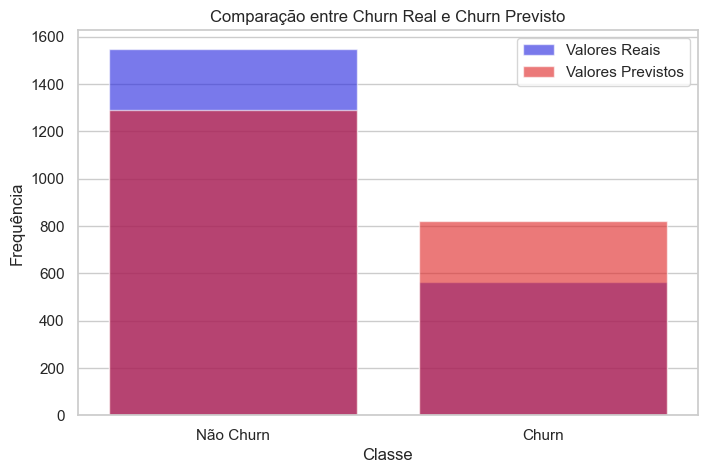

In [353]:
#Criando gráfico de barras para comparar valores reais e previstos
plt.figure(figsize=(8, 5))
sns.countplot(x="Churn", data=df_results, color="blue", alpha=0.6, label="Valores Reais")   #churn = valores reais e label = valores previstos
sns.countplot(x="Label", data=df_results, color="red", alpha=0.6, label="Valores Previstos")

#Configurando titulo e eixos
plt.legend()
plt.title("Comparação entre Churn Real e Churn Previsto")
plt.xlabel("Classe")
plt.ylabel("Frequência")
plt.xticks([0, 1], ["Não Churn", "Churn"])
plt.show()


O modelo parece ter um leve viés para superestimar churn, **mas ainda está capturando uma boa quantidade de casos reais.**


# **Deployment**

In [342]:
with open('../models/model.pkl', 'wb') as model_file:
    pickle.dump(tunned_model, model_file)